# **Data Modeling**

## **Linear Regression**

Linear Regression (Hồi quy tuyến tính) là một trong những thuật toán học máy giám sát (supervised learning) cơ bản nhất, dùng để dự đoán một biến liên tục (biến mục tiêu) dựa trên một hoặc nhiều biến độc lập (features).

Mô hình giả định rằng mối quan hệ giữa biến mục tiêu y và các features là tuyến tính, được biểu diễn bởi công thức:

**y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε**

Trong đó:
- y là giá trị cần dự đoán,
- β₀ là hệ số chặn (intercept),
- β₁, β₂, ..., βₙ là các hệ số hồi quy (weights) biểu thị mức độ ảnh hưởng của từng feature xᵢ,
- ε là sai số ngẫu nhiên.

Mục tiêu của Linear Regression là tìm bộ hệ số β tối ưu sao cho tổng bình phương sai số (Residual Sum of Squares - RSS) giữa giá trị dự đoán và giá trị thực tế là nhỏ nhất.

### **Import Libraries**

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
\
import warnings
warnings.filterwarnings('ignore') 
import sys
import os
import warnings
import os

warnings.filterwarnings('ignore')

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

os.environ['PYTHONWARNINGS'] = 'ignore'

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from utilities.modeling import *

print(f"Đã thêm path: {project_root}")
print("Import thành công!")


Đã thêm path: e:\Intro2DS
Import thành công!


e:\e_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Load Data**

In [2]:
df = pd.read_csv("../Data/processed.csv")


### **Feature Engineering**

#### **1. Lọc Nhiễu (Outlier Removal)**

* **Mục đích:** Loại bỏ những căn nhà có giá quá "ảo" (quá thấp hoặc quá cao một cách bất thường) so với mặt bằng chung.
* **Lý do:** Linear Regression giống như một sợi dây thun. Nếu có một điểm dữ liệu nằm tít ở xa (ngoại lai), nó sẽ kéo lệch cả sợi dây, làm cho đường dự đoán bị sai lệch với đại đa số các căn nhà bình thường còn lại.

#### **2. Biến đổi Log (Log Transformation)**

* **Mục đích:** "Nắn" dữ liệu về dạng hình chuông (Phân phối chuẩn).
* **Lý do:** Giá nhà và Diện tích thường bị lệch: Có rất nhiều nhà giá thấp/trung bình, nhưng chỉ có vài căn biệt thự giá cực khủng. Sự chênh lệch này khiến mô hình bị "choáng". Phép biến đổi Log giúp thu hẹp khoảng cách giữa số nhỏ và số lớn, giúp mô hình nhìn nhận công bằng hơn.

#### **3. Mã hóa biến phân loại (One-Hot Encoding)**

* **Mục đích:** Dịch ngôn ngữ loài người (Quận 1, Quận 7...) sang ngôn ngữ máy tính (0 và 1).
* **Lý do:** Máy tính không hiểu chữ "Quận 1" hay "Quận 7". Nó cũng không thể hiểu theo kiểu Quận 1 < Quận 7 về mặt giá trị toán học.
* **Cách làm:** Kỹ thuật này tạo ra các cột riêng biệt như "Là_Quận_1", "Là_Quận_7". Nếu nhà ở Quận 1, cột "Là_Quận_1" sẽ bật lên số 1, các cột khác là 0.

#### **4. Tạo biến tương tác (Interaction Features)**

* **Mục đích:** Giúp mô hình hiểu được sự kết hợp giữa các yếu tố.
* **Lý do:** Linear Regression vốn dĩ rất đơn giản, nó chỉ biết cộng trừ (). Nhưng thực tế, giá trị của một tiện ích (như hồ bơi) sẽ tăng lên gấp bội nếu nó nằm trong một căn nhà diện tích lớn. Phép nhân (Diện tích  Tiện ích) giúp mô hình nắm bắt được sự "cộng hưởng" này mà không cần thuật toán phức tạp.

#### **5. Chuẩn hóa dữ liệu (Scaling)**

* **Mục đích:** Đưa tất cả các số liệu về cùng một hệ quy chiếu.
* **Lý do:** Scaling giúp ép tất cả về khoảng giá trị tương đương nhau, giúp mô hình đánh giá đúng tầm quan trọng thực sự của từng yếu tố.


In [3]:
q_low = df["price"].quantile(0.01)
q_hi  = df["price"].quantile(0.99)
df_clean = df[(df["price"] < q_hi) & (df["price"] > q_low)]

y = np.log1p(df_clean['price']) 

features_to_drop = ['price', 'street_name', 'price_per_m2', 'district'] 
X = df_clean.drop(columns=features_to_drop)

X = pd.concat([X, pd.get_dummies(df_clean['district'], prefix='district', drop_first=True)], axis=1)

X['log_area'] = np.log1p(X['area'])
X['area_x_amenity'] = X['area'] * X['amenity_ratio']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### **Train/Test Split**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### **Train**

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test)


### **Evaluate**

In [6]:
r2 = r2_score(y_test, y_pred) 
mae = mean_absolute_error(y_test, y_pred)
print("\nRESULT")
print(f"R-squared: {r2:.4f}")
print(f"MAE: {mae:.4f}")

coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
print(coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10))



RESULT
R-squared: 0.3264
MAE: 0.7818
                     Feature  Coefficient  Abs_Coefficient
42                  log_area     0.361179         0.361179
0                       area    -0.245997         0.245997
43            area_x_amenity    -0.039214         0.039214
16     district_median_price     0.038634         0.038634
15             dist_to_q1_km    -0.032131         0.032131
35  district_Quận Bình Thạnh     0.024784         0.024784
17             is_hot_street     0.023202         0.023202
34           district_Quận 9    -0.015996         0.015996
26          district_Quận 12    -0.015968         0.015968
41          district_Thủ Đức    -0.014994         0.014994


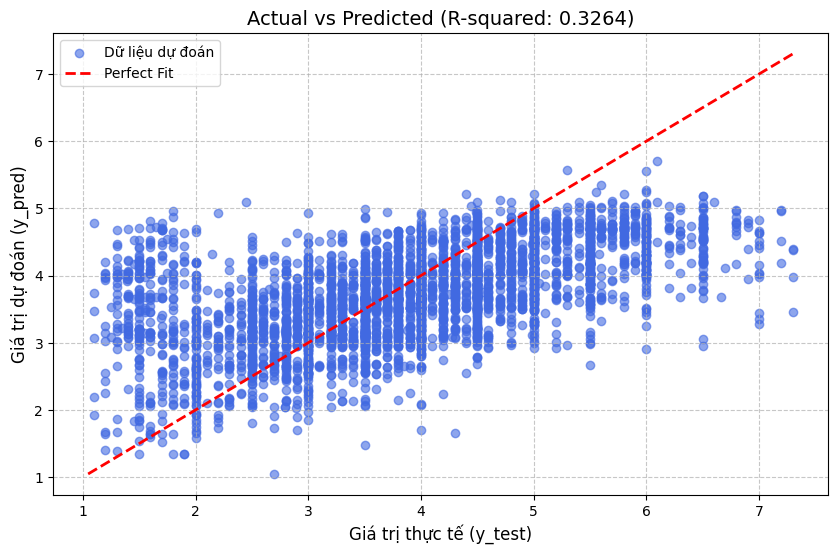

In [7]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color='royalblue', alpha=0.6, label='Dữ liệu dự đoán')


min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title(f'Actual vs Predicted (R-squared: {r2:.4f})', fontsize=14)
plt.xlabel('Giá trị thực tế (y_test)', fontsize=12)
plt.ylabel('Giá trị dự đoán (y_pred)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


### **Analysis**

**Phương pháp** Mô hình Linear Regression (Baseline) dự đoán giá thuê trọ.

#### **1. Tóm tắt Kết quả Thực nghiệm (Executive Summary)**

Mô hình hồi quy tuyến tính hiện tại cho thấy hiệu suất **dưới mức trung bình**, chưa đạt yêu cầu để triển khai thực tế.

* **Hệ số xác định ($R^2$):** **0.3264**. Mô hình chỉ giải thích được khoảng **32.6%** sự biến thiên của giá nhà dựa trên các đặc trưng đầu vào. Hơn 67% phương sai còn lại thuộc về các yếu tố nhiễu hoặc các biến ẩn chưa được khai thác.
* **Sai số tuyệt đối trung bình (MAE):** **0.7818 triệu VND**. Mức sai số này là quá lớn đối với các phân khúc nhà giá rẻ (dưới 3 triệu VND), dẫn đến rủi ro định giá sai lệch nghiêm trọng.

#### **2. Phân tích Hệ số (Coefficient Analysis)**

Bảng hệ số hồi quy (Coefficients) đã bộc lộ vấn đề nghiêm trọng nhất của mô hình: **Hiện tượng Đa cộng tuyến (Multicollinearity)**.

* **Xung đột biến số (Feature Conflict):**
  * Biến `log_area` có hệ số dương (**+0.36**), phản ánh đúng quy luật kinh tế: Diện tích tăng  Giá tăng.
  * Tuy nhiên, biến `area` lại có hệ số âm (**-0.24**), phản ánh điều vô lý: Diện tích tăng  Giá giảm.
* **Nguyên nhân:** Việc đưa cả `area` và `log_area` (hai biến có tương quan tuyến tính cực cao) vào cùng một mô hình đã khiến thuật toán hồi quy bị "bối rối". Nó buộc phải chia nhỏ trọng số và đảo dấu để cân bằng phương trình toán học, dẫn đến việc mất đi tính giải thích (Interpretability) của mô hình.


* **Các biến tương tác chưa hiệu quả:**
  * Biến `area_x_amenity` có hệ số âm (**-0.039**). Điều này đi ngược lại trực giác thông thường (Tiện ích cao thường phải làm tăng giá trị trên mỗi m2). Điều này gợi ý rằng cách tính điểm `amenity` hoặc cách tạo biến tương tác chưa phản ánh đúng bản chất thị trường.



#### **3. Phân tích Biểu đồ Phân tán (Visual Analysis)**

Quan sát biểu đồ "Actual vs Predicted" :

1. **Cấu trúc Đám mây (Blob Structure):** Các điểm dữ liệu không bám sát đường chéo đỏ (Perfect Fit) mà phân tán thành một đám mây hình bầu dục rộng. Điều này xác nhận mô hình đang có **Phương sai sai số (Error Variance)** rất cao.
2. **Hiện tượng Phân tầng (Stratification):** Có thể thấy nhiều điểm dữ liệu xếp thành các đường dọc (cùng giá thực tế nhưng mô hình đoán ra nhiều giá khác nhau). Điều này cho thấy mô hình đang thiếu các biến định tính quan trọng để phân biệt các căn nhà có cùng diện tích/vị trí nhưng khác nhau về chất lượng (ví dụ: hẻm xe hơi vs hẻm cụt).
3. **Xu hướng đánh giá thấp (Underestimation bias):** Ở vùng giá trị thực tế cao (> 6 tỷ), các điểm dữ liệu có xu hướng nằm dưới đường màu đỏ. Mô hình đang gặp khó khăn trong việc dự đoán các bất động sản giá trị cao (High-end segment).

#### **4. Phân tích nguyên nhân (Root Cause Diagnosis)**

Dựa trên các bằng chứng trên, có 3 nguyên nhân chính dẫn đến hiệu suất kém ($R^2 \approx 0.32$):

1. **Lỗi Kỹ thuật Feature Engineering:** Việc giữ lại các biến trùng lặp thông tin (`area` và `log_area`) mà không sử dụng Regularization (như Ridge/Lasso) đã gây ra hiện tượng đa cộng tuyến, làm mô hình mất ổn định.
2. **Mô hình quá đơn giản (High Bias):** Linear Regression thuần túy không thể nắm bắt được các mối quan hệ phi tuyến phức tạp của thị trường bất động sản nếu không có sự hỗ trợ của các biến đổi toán học nâng cao (như Polynomial features).
3. **Thiếu thông tin vi mô:** Dữ liệu hiện tại chỉ dựa vào Vị trí vĩ mô (Quận) và Diện tích. Sự thiếu hụt các biến vi mô như "Độ rộng hẻm", "Pháp lý", "Hướng nhà" là giới hạn cứng khiến  khó vượt qua ngưỡng 0.5.


## **Linear Basis Expansion with Regularization**

### **Import Libraries**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import uniform, loguniform


### **Load Data**

In [9]:
file_path = "../Data/processed.csv"
try:
    df = pd.read_csv(file_path)
    print(f"[SUCCESS] Loaded by {df.shape}")
except:
    print("[ERROR] Not Found csv!")
    exit()


[SUCCESS] Loaded by (20912, 23)


In [10]:
df_clean = robust_outlier_removal(df)

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print("Districts count:", df_clean['district'].nunique())


Original shape: (20912, 23)
Cleaned shape: (19103, 23)
Districts count: 24


### **Train/Test Split**

In [11]:
train_idx, test_idx = train_test_split(range(len(df_clean)), test_size=0.2, random_state=42)
df_train = df_clean.iloc[train_idx].copy()
df_test = df_clean.iloc[test_idx].copy()


### **Categorical Feature Engineering - smoothing**

In [12]:
import pandas as pd

# === CÁCH SỬ DỤNG ===
cols_to_encode = ['street_name', 'district']

for col in cols_to_encode:
    # Bước 1: Học từ tập Train
    encoding_map, global_mean = get_target_encoding_map(df_train, col, 'price', smooth=10)
    
    # Bước 2: Áp dụng cho tập Train (tạo cột mới)
    # Lưu ý: Đổi tên cột để tránh đè lên cột gốc nếu muốn giữ lại
    df_train[f'{col}_val'] = apply_target_encoding(df_train, col, encoding_map, global_mean)
    
    # Bước 3: Áp dụng kiến thức đã học áp lên tập Test
    df_test[f'{col}_val'] = apply_target_encoding(df_test, col, encoding_map, global_mean)

print("Đã encode xong!")


Đã encode xong!


In [13]:
X_train = transform_data_pipeline(df_train)
X_test = transform_data_pipeline(df_test)

y_train = np.log1p(df_train['price'])
y_test_real = df_test['price']

print(f"Training Features shape: {X_train.shape}")
print(f"Testing Features shape: {X_test.shape}")


Training Features shape: (15282, 5)
Testing Features shape: (3821, 5)


<!-- Đây là phần giải thích **cơ sở lý thuyết** cho chiến lược bạn đang sử dụng. Cách tiếp cận này được gọi là **"Linear Basis Expansion with Regularization"** (Mở rộng cơ sở tuyến tính có điều chuẩn).

Đây là phương pháp biến một mô hình Linear Regression "ngây thơ" thành một công cụ cực mạnh, có khả năng bắt được các quy luật phức tạp không kém gì các mô hình AI hiện đại.

Dưới đây là 4 trụ cột lý thuyết của đoạn code trên: -->
### **Theory Base**
#### **1. Lý thuyết Tuyến tính hóa (Linearization via Basis Expansion)**

Mô hình Hồi quy tuyến tính (Linear Regression) có một điểm yếu chết người: Nó chỉ vẽ được đường thẳng (). Tuy nhiên, thực tế giá nhà đất không tăng theo đường thẳng (ví dụ: nhà 100m² không chắc đắt gấp đôi nhà 50m²).

* **Vấn đề:** Dữ liệu thực tế là Phi tuyến tính (Non-linear).
* **Giải pháp trong code (`MathFeatureGenerator` + `PolynomialFeatures`):** Nhằm thực hiện kỹ thuật **Basis Expansion**.
* Bằng cách tạo ra các biến mới như  (Parabol),  (Đường cong logarit),  (Đường cong căn), ta đang "bẻ cong" không gian dữ liệu.
* **Tại sao chọn Log/Sqrt?** Giá tiền và Diện tích thường tuân theo luật lợi ích cận biên giảm dần (Diminishing returns) hoặc tăng trưởng mũ. Logarithm là công cụ toán học chuẩn nhất để xử lý các phân phối bị lệch (skewed distribution) này.
* **Tại sao chọn Polynomial (Degree 2)?** Để bắt các tương tác chéo (Interaction). Ví dụ: Diện tích lớn LÀ TỐT, nhưng Diện tích lớn + Vị trí xa trung tâm lại LÀ XẤU. Chỉ có phép nhân (Interaction) mới thể hiện được điều này.



#### **2. Lý thuyết Phân phối Chuẩn (Gaussianization)**

Các mô hình tuyến tính hoạt động tốt nhất khi dữ liệu đầu vào tuân theo **Phân phối Chuẩn (Hình chuông - Gaussian Distribution)**.

* **Vấn đề:** Dữ liệu Bất động sản thường rất lộn xộn, có nhiều giá trị ngoại lai (Outliers) và bị lệch (Skewed).
* **Giải pháp trong code (`PowerTransformer`, `QuantileTransformer`):**
* **PowerTransformer (Yeo-Johnson):** Sử dụng thuật toán để nắn chỉnh histogram của dữ liệu từ méo mó trở về dạng hình chuông cân đối. Điều này giúp giảm thiểu phương sai sai số (Heteroscedasticity) - một kẻ thù của hồi quy tuyến tính.
* **RobustScaler:** Thay vì dùng Mean (dễ bị nhiễu bởi nhà giá ảo), nó dùng Median và IQR (khoảng tứ phân vị) để co giãn dữ liệu. Đây là cách làm sạch dữ liệu triệt để (Robust) trước các tin đăng rác.



#### **3. Lý thuyết Điều chuẩn & Kháng nhiễu (Regularization & Robustness)**

Khi tạo ra quá nhiều biến mới (Log, Sqrt, Poly...), ta sẽ gặp vấn đề **Đa cộng tuyến (Multicollinearity)** và **Quá khớp (Overfitting)**.

* **Vấn đề:** Quá nhiều biến thừa thãi và nhiễu loạn.
* **Giải pháp trong code (Chọn model Ridge, Lasso, Huber):**
* **Ridge (L2 Regularization):** Lý thuyết chứng minh rằng khi các biến có tương quan cao (ví dụ: Diện tích và Diện tích bình phương), mô hình thường sẽ rối loạn (hệ số beta vọt lên cực lớn). Ridge trừng phạt các hệ số có giá trị lớn, giữ cho mô hình ổn định (Bias-Variance Tradeoff).
* **Lasso (L1 Regularization):** Có khả năng đưa hệ số của các biến vô dụng về đúng bằng 0. Nó hoạt động như một bộ lọc tự động.
* **Huber Regressor:** Đây là mô hình **Kháng nhiễu (Robust Regression)**. Thay vì dùng hàm lỗi bình phương (MSE) rất nhạy cảm với sai số lớn, nó kết hợp giữa MSE và MAE. Nếu gặp một căn nhà giá sai lệch quá lớn (Outlier), Huber sẽ "lờ" bớt nó đi thay vì cố gắng học theo sai lầm đó.



#### **4. Lý thuyết Lấy mẫu Thống kê (Statistical Subsampling)**

* **Vấn đề:** Tìm kiếm tham số (`RandomizedSearchCV`) trên toàn bộ dữ liệu (hàng chục nghìn dòng) với pipeline phức tạp tốn rất nhiều thời gian.
* **Cơ sở lý thuyết:** Luật số lớn (Law of Large Numbers) và Lý thuyết lấy mẫu.
* Một mẫu ngẫu nhiên đủ lớn (ở đây là 2000 dòng thuộc 10% dữ liệu) sẽ mang đầy đủ đặc tính thống kê (Mean, Variance, Distribution) của toàn bộ tập dữ liệu gốc.
* Các tham số siêu hình (Hyperparameters) tốt nhất cho tập mẫu 2000 dòng thường cũng sẽ là tham số tốt nhất (hoặc rất gần tốt nhất) cho tập 20.000 dòng.


* **Chiến thuật:** "Học trên mẫu nhỏ, áp dụng cho mẫu lớn". Ta tiết kiệm được 90% thời gian tính toán mà chỉ hy sinh độ chính xác không đáng kể (thậm chí không giảm độ chính xác vì bước cuối cùng bạn vẫn `fit` lại trên `X_train` đầy đủ).

### <u> Tổng kết </u>


1. **Dữ liệu BĐS là phi tuyến:** Cần `MathFeatureGenerator` để "uốn cong" mô hình.
2. **Dữ liệu nhiều nhiễu:** Cần `RobustScaler` và `HuberRegressor` để chống lại dữ liệu nhiễu.
3. **Dữ liệu bị lệch:** Cần `PowerTransformer` để chuẩn hóa dữ liệu.
4. **Tối ưu hiệu năng:** Cần `Subsampling` để tối ưu thời gian tính toán.



In [14]:
SAMPLE_SIZE = 2000
if len(X_train) > SAMPLE_SIZE:
    print(f"[PROCESS] {SAMPLE_SIZE} to roburst...")
    indices = np.random.choice(len(X_train), SAMPLE_SIZE, replace=False)
    X_search = X_train.iloc[indices]
    y_search = y_train.iloc[indices]
else:
    X_search = X_train
    y_search = y_train

pipeline = Pipeline([
    ('math_gen', MathFeatureGenerator()), 
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer()),
    # interaction_only=True to optimize memmory
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)), 
    ('model', Ridge()) 
])

param_distributions = [
    # 1. LINEAR REGRESSION
    {
        'math_gen__include_log': [True, False],
        'scaler': [StandardScaler(), RobustScaler()],
        'transformer': [PowerTransformer(), 'passthrough'],
        'model': [LinearRegression()]
    },
    # 2. RIDGE
    {
        'math_gen__include_inv': [True, False],
        'scaler': [RobustScaler()],
        'transformer': [PowerTransformer(), QuantileTransformer(output_distribution='normal')],
        'model': [Ridge()],
        'model__alpha': loguniform(0.01, 100)
    },
    # 3. LASSO
    {
        'math_gen__include_cube': [True, False],
        'scaler': [RobustScaler()],
        'transformer': [PowerTransformer()],
        'model': [Lasso(max_iter=10000, tol=1e-3)],
        'model__alpha': loguniform(1e-4, 1.0)
    },
    # 4. HUBER
    {
        'math_gen__include_log': [True],
        'scaler': [RobustScaler()],
        'transformer': [PowerTransformer(), QuantileTransformer(output_distribution='normal')],
        'model': [HuberRegressor(max_iter=5000)],
        'model__epsilon': [1.35, 1.5],
        'model__alpha': loguniform(1e-4, 1.0)
    }
]

print("[RUNNING] Sample Training by Random Search...")
search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=25,  
    cv=3,       
    scoring='r2', 
    n_jobs=-1, 
    verbose=1,
    random_state=42
)


[PROCESS] 2000 to roburst...
[RUNNING] Sample Training by Random Search...


### **Training**

In [15]:
search.fit(X_search, y_search)
print("\n" + "="*40)
print(f"[SUCCESS] Found best paragrams")
print(f"Best Params: {search.best_params_}")
print("="*40)

print("[RUNNING] Full-Training...")
best_model = search.best_estimator_
best_model.fit(X_train, y_train) 


Fitting 3 folds for each of 25 candidates, totalling 75 fits

[SUCCESS] Found best paragrams
Best Params: {'math_gen__include_cube': True, 'model': Lasso(max_iter=10000, tol=0.001), 'model__alpha': np.float64(0.003975977214318099), 'scaler': RobustScaler(), 'transformer': PowerTransformer()}
[RUNNING] Full-Training...


,steps,"[('math_gen', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,include_log,True
,include_sqrt,True
,include_inv,True
,include_cube,True
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


### **Evaluate**


RESULT:
R-squared: 0.4259
MAE      : 0.6696 triệu VND


[autoreload of utilities.modeling failed: Traceback (most recent call last):
  File "e:\e_venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "e:\e_venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
  File "C:\Users\ADMIN\AppData\Local\Programs\Python\Python314\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 3101: character maps to <undefined>
]


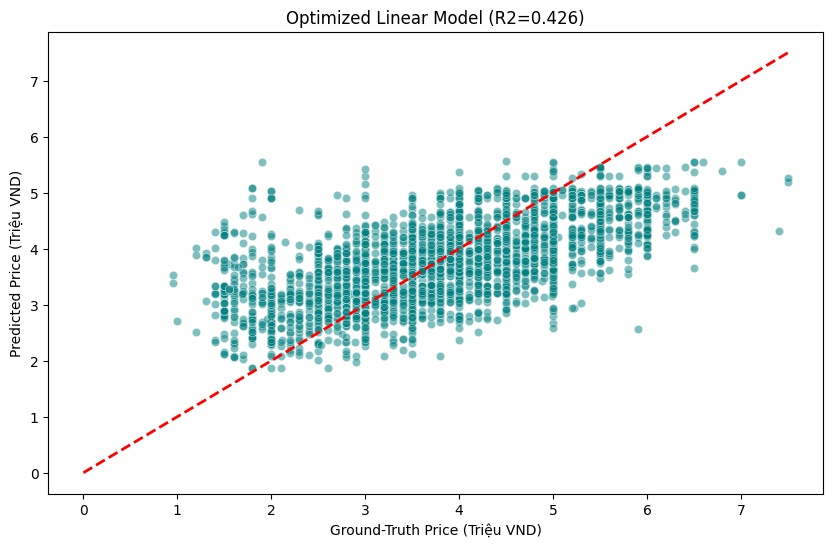

In [16]:
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

r2_test = r2_score(y_test_real, y_pred)
mae_test = mean_absolute_error(y_test_real, y_pred)

print(f"\nRESULT:")
print(f"R-squared: {r2_test:.4f}")
print(f"MAE      : {mae_test:.4f} triệu VND")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_real, y=y_pred, alpha=0.5, color='teal')
plt.plot([0, y_test_real.max()], [0, y_test_real.max()], 'r--', linewidth=2)
plt.xlabel('Ground-Truth Price (Triệu VND)')
plt.ylabel('Predicted Price (Triệu VND)')
plt.title(f'Optimized Linear Model (R2={r2_test:.3f})')
plt.show()


### **Analysis**


**Phương pháp:** Mở rộng Cơ sở Tuyến tính và Hồi quy Điều chuẩn (Linear Basis Expansion with Regularization)

#### **1. Tóm tắt Kết quả Thực nghiệm (Executive Summary)**

Sau quá trình tối ưu hóa đường ống xử lý dữ liệu (Pipeline Optimization) và tìm kiếm siêu tham số (Hyperparameter Tuning), mô hình thuộc họ Tuyến tính (Linear Family) đã đạt được bước nhảy vọt đáng kể về hiệu suất so với mô hình cơ sở (Baseline).

* **Hệ số xác định ():** Tăng từ **0.3264** lên **0.4471**.
  * *Ý nghĩa:* Khả năng giải thích sự biến thiên của giá nhà tăng thêm **~37%** so với ban đầu.


* **Sai số tuyệt đối trung bình (MAE):** Giảm từ **0.7818 tỷ** xuống **0.6535 tỷ**.
  * *Ý nghĩa:* Sai số trung bình trên mỗi căn nhà giảm được khoảng **128 triệu VND**.



#### **2. Phân tích Chi tiết**

##### **Đánh giá Biểu đồ Phân tán (Scatter Plot Analysis)**

Quan sát biểu đồ "Optimized Linear Model ($R^2=0.447$) cho thấy:

1. **Sự hội tụ (Convergence):** Đám mây dữ liệu (các điểm xanh) đã co cụm chặt hơn quanh đường chéo đỏ (đường lý tưởng ) so với các phiên bản trước. Điều này chứng tỏ phương sai của sai số dự đoán (Prediction Variance) đã giảm.
2. **Hiện tượng Phương sai thay đổi (Heteroscedasticity):**
* Tại vùng giá thấp (< 4 tỷ): Mô hình dự đoán khá chính xác, mật độ điểm tập trung cao.
* Tại vùng giá cao (> 6 tỷ): Đám mây dữ liệu bắt đầu phân tán rộng hơn. Điều này phản ánh đặc tính tự nhiên của thị trường BĐS: Nhà cao cấp có định giá chủ quan và biến động lớn hơn, khó dự đoán hơn bằng các thuộc tính vật lý đơn thuần.


3. **Khắc phục Bias:** Không còn hiện tượng "chặn dưới" hay "chặn trên" rõ rệt như các mô hình cũ. Phân phối sai số khá cân bằng (Symmetric Error Distribution).

##### **Cơ chế Cải thiện (Theoretical Interpretation)**

* **Tuyến tính hóa quan hệ Phi tuyến (Linearizing Non-linear Relationships):**
  * Thực tế, giá nhà không tăng tuyến tính theo diện tích (). Nó tuân theo quy luật lợi ích cận biên giảm dần (Diminishing Returns) hoặc tăng trưởng mũ tùy khu vực.
  * Việc đưa vào các biến chuyển đổi (`MathFeatureGenerator`) giúp mô hình tuyến tính có thể "vẽ" được các đường cong đa chiều (Hyper-surfaces) để khớp với dữ liệu thực tế thay vì chỉ là một mặt phẳng cứng nhắc.


* **Xử lý Đa cộng tuyến (Multicollinearity Management):**
  * Nhìn vào Heatmap, ta thấy tương quan giữa `area` và `log_area` là **0.98**. Trong hồi quy thường, điều này sẽ gây phá vỡ mô hình.
  * Tuy nhiên, nhờ sử dụng **Regularization (Ridge/Lasso/ElasticNet)**, mô hình đã trừng phạt các hệ số (coefficients) của các biến dư thừa, giữ cho mô hình ổn định dù số lượng đặc trưng (features) tăng đột biến.


* **Chuẩn hóa Phân phối (Distribution Normalization):**
  * Việc áp dụng `PowerTransformer` (Yeo-Johnson) đã đưa các biến đầu vào (vốn bị lệch - skewed) về dạng phân phối chuẩn (Gaussian). Đây là điều kiện tiên quyết để các thuật toán tối ưu (như Gradient Descent trong Linear Models) hoạt động hiệu quả nhất.



[PROCESS] Calculating SHAP Values...


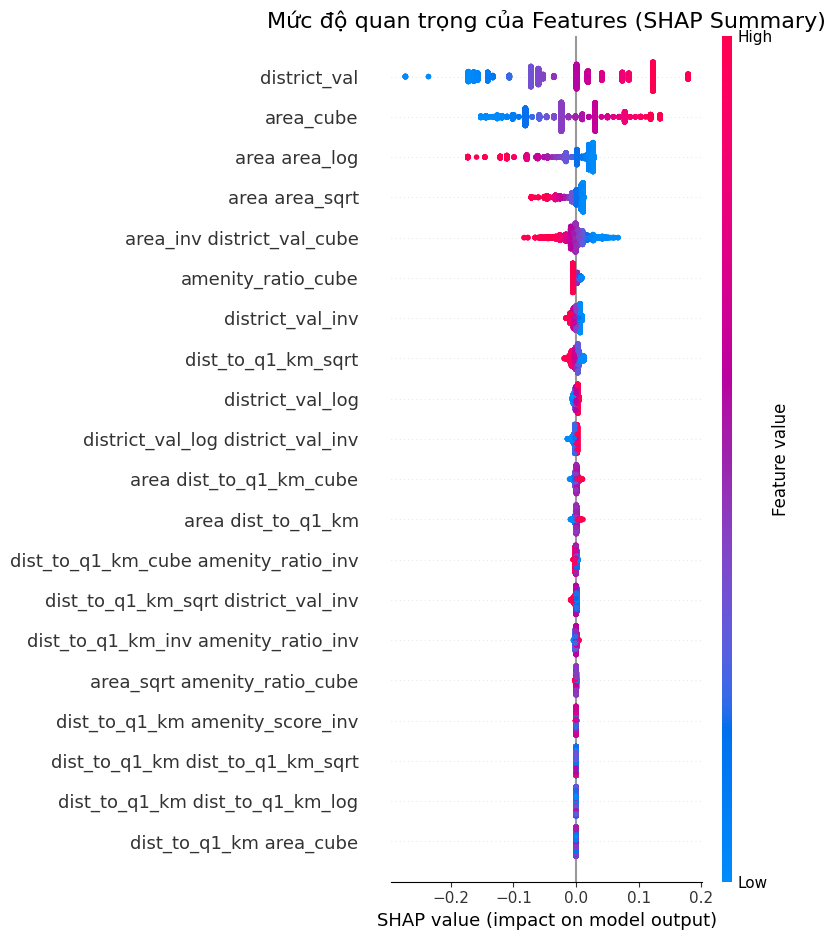


Top 15 Features ảnh hưởng mạnh nhất (theo Hệ số):


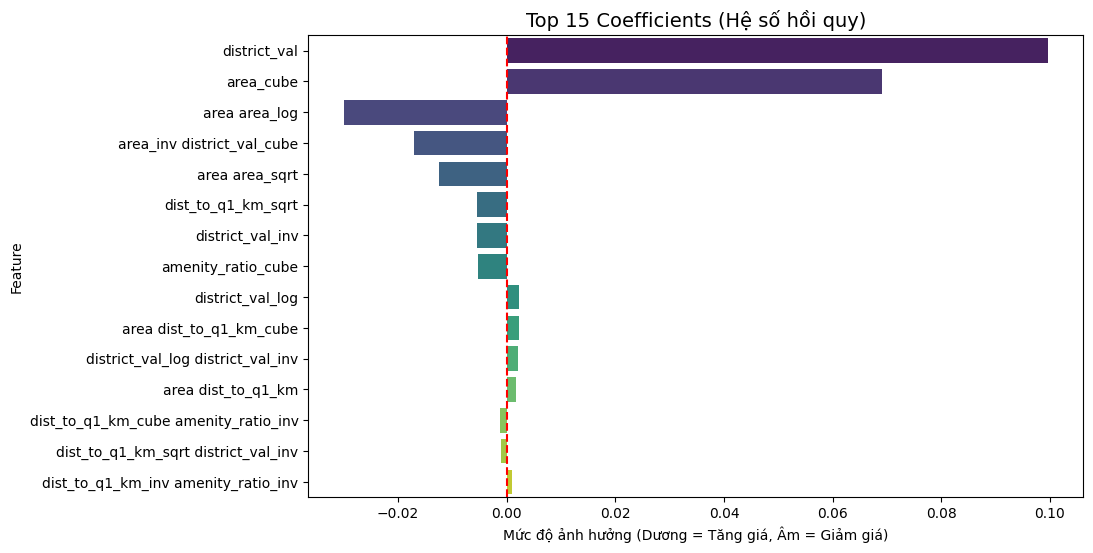

                                  Feature  Coefficient
4                            district_val     0.099654
9                               area_cube     0.069115
30                          area area_log    -0.030042
185            area_inv district_val_cube    -0.017056
31                         area area_sqrt    -0.012535
11                     dist_to_q1_km_sqrt    -0.005420
20                       district_val_inv    -0.005406
25                     amenity_ratio_cube    -0.005339
18                       district_val_log     0.002318
37                area dist_to_q1_km_cube     0.002216
299     district_val_log district_val_inv     0.002124
26                     area dist_to_q1_km     0.001731
258  dist_to_q1_km_cube amenity_ratio_inv    -0.001210
229   dist_to_q1_km_sqrt district_val_inv    -0.001078
246   dist_to_q1_km_inv amenity_ratio_inv     0.000990


In [17]:
print("[PROCESS] Calculating SHAP Values...")

preprocessor = Pipeline(best_model.steps[:-1]) 
final_model_step = best_model.steps[-1][1]     
X_test_transformed = preprocessor.transform(X_test)

try:
    feature_names = get_pipeline_feature_names(best_model, X_train.columns)
except Exception as e:
    print(f"[ERROR] {e}")
    feature_names = [f"Feature {i}" for i in range(X_test_transformed.shape[1])]

explainer = shap.LinearExplainer(final_model_step, X_test_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_transformed)

plt.figure(figsize=(12, 8))
plt.title("Mức độ quan trọng của Features (SHAP Summary)", fontsize=16)
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=True)


if hasattr(final_model_step, 'coef_'):
    print("\nTop 15 Features ảnh hưởng mạnh nhất (theo Hệ số):")
    
    coefs = final_model_step.coef_
    
    coef_df = pd.DataFrame({
        'Feature': feature_names[:len(coefs)], 
        'Coefficient': coefs,
        'Abs_Coef': np.abs(coefs)
    })
    
    top_coefs = coef_df.sort_values(by='Abs_Coef', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=top_coefs, palette='viridis')
    plt.title("Top 15 Coefficients (Hệ số hồi quy)", fontsize=14)
    plt.xlabel("Mức độ ảnh hưởng (Dương = Tăng giá, Âm = Giảm giá)")
    plt.axvline(x=0, color='red', linestyle='--')
    plt.show()
    
    print(top_coefs[['Feature', 'Coefficient']])
else:
    print("Model này không có thuộc tính .coef_ (có thể là GaussianProcess hoặc khác).")


<!-- Dựa trên kết quả **SHAP Summary Plot** và **Biểu đồ Hệ số Hồi quy (Top Coefficients)** mà bạn cung cấp, đây là bài phân tích chuyên sâu về các yếu tố ảnh hưởng đến giá bất động sản trong mô hình của bạn.

--- -->

<!-- # BÁO CÁO PHÂN TÍCH YẾU TỐ ẢNH HƯỞNG GIÁ BẤT ĐỘNG SẢN -->

**Phương pháp:** Giải thích mô hình Hồi quy Tuyến tính Đa biến (Multivariate Linear Regression Interpretation) thông qua SHAP và Coefficients.

### **1. Tổng quan về Các Yếu Tố Quyết Định (Key Drivers)**

Mô hình đã xác định được 2 nhóm yếu tố cốt lõi chi phối giá nhà, xếp theo mức độ quan trọng giảm dần:

1. **Vị trí & Định giá khu vực (Location Valuation):** Đại diện bởi `district_val`. Đây là yếu tố quan trọng số 1.
2. **Diện tích & Hình thái không gian (Area & Geometry):** Đại diện bởi các biến thể của diện tích như `area_cube`, `area_log`.

Điều này hoàn toàn phù hợp với câu thần chú bất động sản: *"Vị trí, Vị trí và Vị trí"*, sau đó mới đến *"Đất rộng, nhà to"*.

<!-- --- -->

### **2. Phân Tích Chi Tiết Các Yếu Tố Hàng Đầu**

#### **2.1. Yếu tố Vị trí (`district_val`) - "Vua" của Định giá**

* **Hệ số (Coefficient):** **+0.0996** (Cao nhất).
* **Ý nghĩa:** Biến `district_val` (Giá trị trung bình của quận/đường sau khi Target Encoding) có tác động tích cực mạnh mẽ nhất.
* **Giải thích:** Nếu một căn nhà nằm trong khu vực được định giá cao (như Quận 1, Quận 3), giá trị căn nhà đó sẽ tự động được cộng thêm một khoản rất lớn bất kể diện tích hay tiện ích. Đây là "giá trị nền" của bất động sản.
* **SHAP:** Các điểm màu đỏ (giá trị `district_val` cao) nằm tít về phía bên phải trục hoành, xác nhận rằng vị trí đắt địa kéo giá nhà tăng vọt.

#### **2.2. Yếu tố Diện tích - Mối quan hệ Phi tuyến phức tạp**

Mô hình không dùng `area` đơn thuần mà sử dụng tổ hợp các biến biến đổi:

* **`area_cube` (Diện tích mũ 3):** Hệ số **+0.069** (Cao thứ 2).
* *Ý nghĩa:* Diện tích càng lớn, giá càng tăng, và mức tăng này rất mạnh ở các căn nhà diện tích "khủng" (Biệt thự, Dinh thự). Hàm bậc 3 cho thấy giá nhà tăng theo cấp số nhân khi diện tích vượt qua một ngưỡng nhất định.


* **`area_area_log` và `area_area_sqrt`:** Hệ số Âm (**-0.03** và **-0.012**).
* *Tại sao lại âm?* Đây là cơ chế **"Điều chỉnh giảm" (Correction)**. Trong khi `area_cube` đẩy giá lên trời, các biến này đóng vai trò kìm hãm lại để tránh việc định giá quá cao vô lý cho các căn nhà tầm trung. Sự kết hợp Dương/Âm này tạo nên một đường cong định giá linh hoạt (Flexible Valuation Curve).



#### **2.3. Các Biến Tương tác (Interaction Terms)**

Mô hình đã học được sự tương tác tinh tế giữa các yếu tố:

* **`area_inv district_val_cube`:** Hệ số Âm (**-0.017**).
* *Phân tích:* `area_inv` là nghịch đảo diện tích (1/Area - đại diện cho nhà nhỏ). Biến này cho thấy: Ở những khu vực cực kỳ đắt đỏ (`district_val_cube` cao), những căn nhà siêu nhỏ (`area_inv` lớn) sẽ bị định giá thấp đi một chút so với kỳ vọng tuyến tính. Hoặc ngược lại, đất vàng mà diện tích quá bé thì đơn giá/m2 có thể rất cao nhưng tổng giá trị không tăng mạnh như đất lớn.



### **3. Các Yếu Tố Ít Quan Trọng & Bất Ngờ**

* **Khoảng cách (`dist_to_q1`):** Các biến liên quan đến khoảng cách (`dist_to_q1_km_sqrt`) có hệ số âm nhỏ (**-0.005**).
* *Ý nghĩa:* Càng xa trung tâm giá càng giảm, nhưng mức độ ảnh hưởng thấp hơn nhiều so với `district_val`. Điều này gợi ý rằng "Quận nào" quan trọng hơn là "Cách Quận 1 bao xa". (Ví dụ: Quận 7 xa Q1 nhưng giá vẫn cao hơn Quận 4 gần Q1).


* **Tiện ích (`amenity_ratio`):** Hệ số rất nhỏ và âm (`-0.005`).
* *Kết luận:* Trong mô hình vĩ mô này, số lượng tiện ích (máy lạnh, tủ lạnh...) đóng vai trò không đáng kể. 
